## Code required to create Figure 1
*From "Exploring uncertainty of trends in the lower-tropospheric North Pacific Jet."* 

Entire notebook takes: ~20 seconds on Intel i7-10750 using > 4GB RAM

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
## Statistics#
from scipy.stats import kendalltau
import pymannkendall

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
START_YEAR = "1980-01"
END_YEAR = "2023-01"

In [3]:
era_npac_day_dict = {}

era_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['GrisePolvani2014_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Grise & Polvani 2014 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
era_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]

era_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]


In [4]:
b18_data = pd.DataFrame([pd.date_range(START_YEAR, periods=43, freq='AS'),\
                         era_npac_day_dict['Bracegirdle2018_NorthPacific']['annual_JPOS'],
                        ]).T
b18_data.columns = ['time', 'annual_JPOS']
b18_data = b18_data.set_index('time')
b18_data = b18_data[START_YEAR:END_YEAR]

In [5]:
## Note Kerr et al. 2020 is lon mean
metric_data = pd.DataFrame(era_npac_day_dict['Woollings2010_NorthPacific']['jet_lat'])
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_w10'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['BarnesPolvani2013_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_bp13'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['GrisePolvani2014_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_gp14'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['BarnesPolvani2015_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_bp15'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['BarnesSimpson2017_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_bs17'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['Ceppi2018_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_c18'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['Zappa2018_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_z18'})
metric_data = pd.concat([metric_data, pd.DataFrame(era_npac_day_dict['Kerr2020_NorthPacific']['jet_lat'])], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_k20'})


In [6]:
metric_data.index = pd.to_datetime(metric_data.index)

In [7]:
metric_data = pd.concat([metric_data, b18_data], axis=1)
metric_data = metric_data.rename(columns={'jet_lat':'jet_lat_b18'})

In [8]:
metric_data

,jet_lat_w10,jet_lat_bp13,jet_lat_gp14,jet_lat_bp15,jet_lat_bs17,jet_lat_c18,jet_lat_z18,jet_lat_k20,annual_JPOS
time,,,,,,,,,
1980-01-01,NaN,NaN,40.92,38.926207,27.5,37.309215,36.836718,41.722453,39.575
1980-01-02,NaN,NaN,38.71,29.795892,NaN,35.516798,35.117238,40.218815,NaN
1980-01-03,NaN,NaN,28.76,NaN,NaN,32.761965,32.468994,38.408524,NaN
1980-01-04,NaN,NaN,27.82,21.179263,NaN,35.013194,33.788064,42.743243,NaN
1980-01-05,NaN,NaN,28.53,NaN,NaN,39.291034,35.794402,38.217256,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,NaN,34.61,33.235372,NaN,34.998392,34.397447,37.645530,NaN
2022-12-28,NaN,NaN,38.18,38.531880,NaN,36.674997,36.537415,36.316528,NaN
2022-12-29,NaN,NaN,38.95,41.061983,NaN,38.134560,37.955359,37.262994,NaN


In [9]:
metric_data['annual_JPOS'] = metric_data['annual_JPOS'].astype(float)

In [10]:
AA_data = xr.open_dataset('/home/thomaskeel/Dev/Climate Data/ERA-5/era5_temp_AA_80to22.nc')

In [11]:
TA_data = xr.open_dataset('/home/thomaskeel/Dev/Climate Data/ERA-5/era5_temp_TA_80to22.nc')

In [12]:
PVS_data = xr.open_dataset('/home/thomaskeel/Dev/Climate Data/ERA-5/era5_u_wind_SPV_80to22.nc')

In [13]:
# convert from Kelvin to Celcius
AA_data['t'] = AA_data['t'] - 273.15
TA_data['t'] = TA_data['t'] - 273.15

In [14]:
## Get mean
AA_data_mean = AA_data.mean(('longitude', 'latitude', 'level'))

In [15]:
TA_data_mean = TA_data.mean(('longitude', 'latitude', 'level'))

In [16]:
PVS_data_mean = PVS_data.mean(('longitude', 'latitude', 'level'))

# Make Figure 1

In [17]:
## merge all climatological data to jet statistic data
clim_data = pd.DataFrame() 
clim_data['AA'] =  (AA_data_mean.groupby('time.dayofyear') - AA_data_mean.groupby('time.dayofyear').mean('time')).to_dataframe()['t'] 
clim_data['TA'] =  (TA_data_mean.groupby('time.dayofyear') - TA_data_mean.groupby('time.dayofyear').mean('time')).to_dataframe()['t'] 
clim_data['PVS'] =  (PVS_data_mean.groupby('time.dayofyear') - PVS_data_mean.groupby('time.dayofyear').mean('time')).to_dataframe()['u'] 
all_data = pd.concat([clim_data, metric_data], axis=1)

In [18]:
def get_linear_reg_slope(data, col_name):
    lin_reg_data = prepare_data_for_linear_reg(data, col_name)
    return linear_reg_slope(lin_reg_data)


def prepare_data_for_linear_reg(data, col_name):
    values = data[col_name].values.astype(float)
    ordinal_dates = get_ordinal_dates(data)
    lin_reg_data = pd.DataFrame([values, ordinal_dates]).T
    lin_reg_data = lin_reg_data.dropna()
    return lin_reg_data


def get_ordinal_dates(data, index_col_name='time'):
    return pd.to_datetime(data.reset_index()[index_col_name]).apply(lambda date: date.toordinal())


def linear_reg_slope(data):
    """
        data[0] should be values, data[1] should be ordinal dates
    """
    slope, intercept = np.polyfit(data[1], data[0], 1)
    lr1d = np.poly1d([slope, intercept])(data[1])
    return pd.DataFrame(lr1d, index=data[1].apply(lambda row: pd.to_datetime(datetime.date.fromordinal(int(row)))), columns=['reg_line'])

In [19]:
all_data_1m_resampled = all_data.resample('1m').mean()

In [20]:
all_data_1m_resampled.head()

,AA,TA,PVS,jet_lat_w10,jet_lat_bp13,jet_lat_gp14,jet_lat_bp15,jet_lat_bs17,jet_lat_c18,jet_lat_z18,jet_lat_k20,annual_JPOS
time,,,,,,,,,,,,
1980-01-31,0.088043,-0.168350,-0.123530,NaN,28.978000,31.850968,39.819157,30.375000,34.173647,32.869577,38.466552,39.575
1980-02-29,0.547434,0.036724,2.281606,32.301724,32.391379,32.035862,36.883040,31.250000,33.935830,33.208474,36.781561,NaN
1980-03-31,0.229189,-0.206726,-2.834687,42.258065,42.416774,42.293548,42.481805,42.187500,40.757776,40.451044,40.875511,NaN
1980-04-30,-0.865255,-0.045067,-1.351200,41.225000,41.389333,41.230333,43.052097,41.083333,41.057713,40.949765,41.818711,NaN
1980-05-31,0.094556,0.154430,-1.122934,43.314516,43.451935,43.809032,43.858021,44.083333,42.319845,42.251955,43.449316,NaN


In [23]:
all_kendall_corr = {}
for clim_col in ['AA', 'TA', 'PVS']:
    for jet_lat in ['w10', 'bp13', 'gp14', 'bs17', 'z18', 'k20']:
        tau, p = kendalltau(all_data_1m_resampled[clim_col], all_data_1m_resampled[f'jet_lat_{jet_lat}'], nan_policy='omit')
        all_kendall_corr[f"{clim_col}_{jet_lat}"] = [tau, p]

In [24]:
all_kendall_corr_df = pd.DataFrame(all_kendall_corr).T
all_kendall_corr_df.columns = ['tau', 'pval']

In [29]:
all_kendall_corr_df

,tau,pval
AA_w10,-0.054517,0.064408
AA_bp13,-0.055002,0.061798
AA_gp14,-0.067209,0.022473
AA_bs17,-0.046953,0.111553
AA_z18,-0.060360,0.040393
AA_k20,-0.069737,0.017877
TA_w10,0.009823,0.738972
TA_bp13,0.006616,0.822251
TA_gp14,0.002852,0.922835
TA_bs17,-0.004487,0.879131


In [25]:
all_kendall_corr_df.head(7) ## all sig except TA_w10 

,tau,pval
AA_w10,-0.054517,0.064408
AA_bp13,-0.055002,0.061798
AA_gp14,-0.067209,0.022473
AA_bs17,-0.046953,0.111553
AA_z18,-0.060360,0.040393
AA_k20,-0.069737,0.017877
TA_w10,0.009823,0.738972


In [26]:
WINDOW_SIZE = 12 # 12 months

Mann Kendall test for AA trend increasing p-value: 0.0 slope 0.046891524574973364
Mann Kendall test for TA trend increasing p-value: 0.0 slope 0.019705743500680634
Mann Kendall test for PVS trend no trend p-value: 0.16925439148731614 slope -0.009360623359680176
Mann Kendall test for jet_lat_w10 trend no trend p-value: 0.12012580447455634 slope 0.022022332506203394
Mann Kendall test for jet_lat_bp13 trend no trend p-value: 0.09418942913133277 slope 0.02428283121831533
Mann Kendall test for jet_lat_gp14 trend increasing p-value: 0.03549201595248208 slope 0.025110356536502895
Mann Kendall test for jet_lat_bs17 trend no trend p-value: 0.12621401291731393 slope 0.02000065308254955
Mann Kendall test for annual_JPOS trend no trend p-value: 0.28440041679537575 slope 0.01818181818181801
Mann Kendall test for jet_lat_z18 trend increasing p-value: 0.031236324813573635 slope 0.017945849511329277
Mann Kendall test for jet_lat_k20 trend increasing p-value: 0.007106626081966327 slope 0.01916227070089

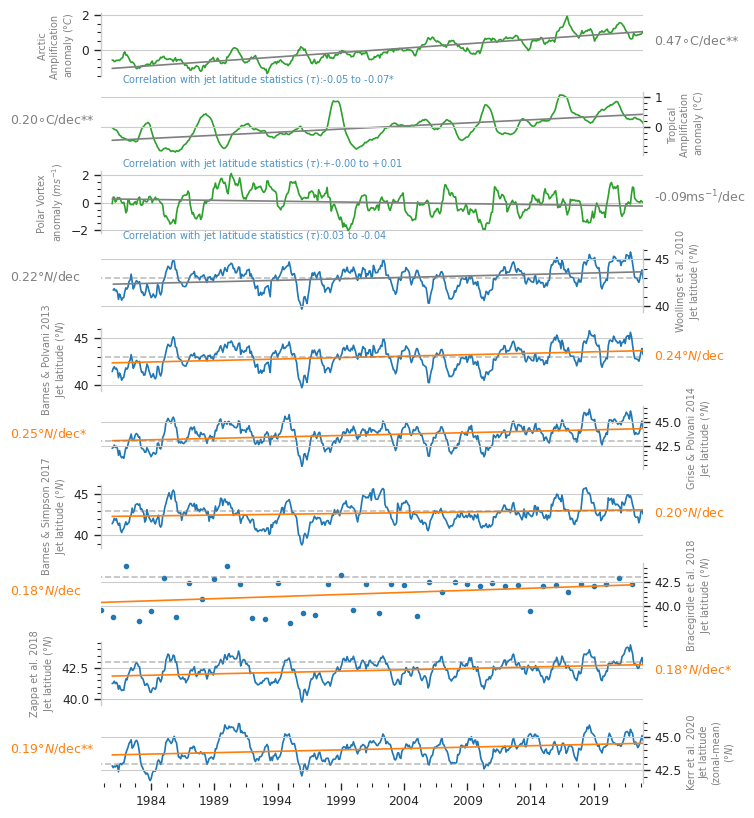

In [28]:
sns.set_style('whitegrid')
sns.set_context('paper')
fig, axes = plt.subplots(10, 1, figsize=(7, 10), sharex=True, \
                         height_ratios=[0.5, 0.5,0.5, 0.5, 0.5, 0.5, 0.5,0.5, 0.5, 0.5])
# all_data_rolling = all_data.rolling(window=365).mean()
# all_data_rolling_missing_vals = all_data.rolling(window=365, min_periods=8).mean()
# all_data_rolling['temp_anom'] = (all_data_rolling['t2m'] - all_data_rolling['t2m'].mean())
cols_to_plot = ['AA', 'TA', 'PVS',\
                'jet_lat_w10', 'jet_lat_bp13', 'jet_lat_gp14', 'jet_lat_bs17',\
                'annual_JPOS', 'jet_lat_z18', 'jet_lat_k20'] #'jet_lat_bp15',

ylabels = ["Arctic \nAmplification \nanomaly (${\degree C}$)", "Tropical \nAmplification \nanomaly (${\degree C}$)", "Polar Vortex \nanomaly ($ms^{-1}$)",\
           "Woollings et al. 2010\nJet latitude (${\degree N}$)",\
           "Barnes & Polvani 2013\nJet latitude (${\degree N}$)",\
           "Grise & Polvani 2014\nJet latitude (${\degree N}$)",\
           "Barnes & Simpson 2017\nJet latitude (${\degree N}$)",\
          "Bracegirdle et al. 2018\nJet latitude (${\degree N}$)",\
           "Zappa et al. 2018\nJet latitude (${\degree N}$)",\
          "Kerr et al. 2020\nJet latitude\n(zonal-mean)\n(${\degree N}$)"]

slope_units = ["${\circ}$C/dec", "${\circ}$C/dec", "ms$^{-1}$/dec"]
all_data_1m_resampled['AA'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[0], c='C2')
all_data_1m_resampled['TA'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[1], c='C2')
all_data_1m_resampled['PVS'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[2], c='C2')
all_data_1m_resampled['jet_lat_w10'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[3], c="C0")
all_data_1m_resampled['jet_lat_bp13'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[4], c="C0")
all_data_1m_resampled['jet_lat_gp14'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[5], c="C0")
all_data_1m_resampled['jet_lat_bs17'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[6], c="C0")
all_data_1m_resampled['annual_JPOS'].plot(ax=axes[7], marker='o', markersize=3, c="C0")
all_data_1m_resampled['jet_lat_z18'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[8], c="C0")
all_data_1m_resampled['jet_lat_k20'].rolling(window=WINDOW_SIZE).mean().plot(ax=axes[9], c="C0")


counter = 0 
for ax, col_name, ylabel in zip(axes, cols_to_plot, ylabels):
    if counter % 2 == 1:
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        twin_ax = ax.twinx()
        twin_ax.set_ylim(ax.get_ylim())
        twin_ax.spines['top'].set_visible(False) 
        twin_ax.spines['bottom'].set_visible(False)
        twin_ax.spines['left'].set_visible(False)
        ax.spines['left'].set_visible(False)
        twin_ax.set_ylabel(ylabel, size=7, color='grey')
        twin_ax.minorticks_on()
        twin_ax.tick_params(axis='y',which='major', right=True)
        twin_ax.tick_params(axis='y',which='minor', right=True)
        twin_ax.hlines(43, 0, 680, color='gray', alpha=0.5, linestyle='--')
        ax.set_yticks([])
    else:
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_ylabel(ylabel, size=7, color='grey'); 
    
    ax.spines['top'].set_visible(False); 
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False); 
    ax.set_title('')
    if col_name == "annual_JPOS":
        color_to_use = 'C1'
        lin_reg_line = get_linear_reg_slope(pd.DataFrame(all_data_1m_resampled[col_name]), col_name)
        lin_reg_line.index = lin_reg_line.index + pd.DateOffset(months=12)
        lin_reg_line.plot(ax=ax, c=color_to_use, legend=False)
    elif col_name in cols_to_plot[:4]:
        color_to_use = 'C7'
        lin_reg_line = get_linear_reg_slope(pd.DataFrame(all_data_1m_resampled[col_name].rolling(window=WINDOW_SIZE).mean()), col_name)
        lin_reg_line.plot(ax=ax, c=color_to_use, legend=False)
    else:
        color_to_use = 'C1'
        lin_reg_line = get_linear_reg_slope(pd.DataFrame(all_data_1m_resampled[col_name].rolling(window=WINDOW_SIZE).mean()), col_name)
        lin_reg_line.plot(ax=ax, c='C1', legend=False)
    # if counter == 4:
    #     break
    # slope_by_year = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
    if counter < 3:
        slope_label = slope_units[counter]
    else:
        slope_label = "${\degree N}$/dec"
        
    ## run Mann-Kendall test
    if col_name == 'annual_JPOS':
        mktest = pymannkendall.original_test(all_data_1m_resampled[col_name].dropna())
    elif col_name in cols_to_plot[:4]:
        mktest = pymannkendall.seasonal_test(all_data_1m_resampled[col_name].dropna(), period=12)
    else:
        mktest = pymannkendall.seasonal_test(all_data_1m_resampled[col_name].dropna(), period=12)
    print("Mann Kendall test for", col_name, "trend", mktest.trend, "p-value:", mktest.p, "slope", mktest.slope)
    if mktest.p <= 0.05:
        slope_label += "*"
    if mktest.p <= 0.01:
        slope_label += "*"
    else:
        pass
    slope_by_decade = mktest.slope*10
    if counter % 2 == 1:
        ymin, ymax = twin_ax.get_ylim()
        twin_ax.text(s=f"{slope_by_decade:.2f}{slope_label}", x=34, y=(ymin + ymax)/2, fontsize=9, c=color_to_use)
    else:
        ymin, ymax = ax.get_ylim()
        ax.text(s=f"{slope_by_decade:.2f}{slope_label}", x=ax.get_xlim()[-1]+10, y=(ymin + ymax)/2, fontsize=9, c=color_to_use)
        
    ax.grid(axis='x')
    ax.minorticks_on()
    ax.tick_params(axis='y',which='major', left=True)
    ax.tick_params(axis='y',which='minor', left=True)
    counter += 1

for n in range(0, 3):
    xmin, xmax = axes[n].get_xlim()
    ymin, ymax = axes[n].get_ylim()
    tau_pval_col = all_kendall_corr_df[all_kendall_corr_df.index.str.startswith(cols_to_plot[n])]
    tau_min, tau_min_pval = tau_pval_col['tau'].min(), tau_pval_col.iloc[tau_pval_col['tau'].argmin()]['pval']
    tau_max, tau_max_pval = tau_pval_col['tau'].max(), tau_pval_col.iloc[tau_pval_col['tau'].argmax()]['pval']
    min_asterix, max_asterix = "", ""     
    if tau_min_pval < 0.05:
        min_asterix += "*"
    if tau_min_pval < 0.01:
        min_asterix += "*" 
    if tau_max_pval < 0.05:
        max_asterix += "*"
    if tau_max_pval < 0.01:
        max_asterix += "*" 
    if abs(tau_min) > abs(tau_max):
        axes[n].text(s="Correlation with jet latitude statistics "+r"($\tau$):"+f"{tau_max:.2f}{max_asterix} to {tau_min:.2f}{min_asterix}", x=xmin+20, y=ymin-.4, fontsize=7, c='C0', alpha=.8)
    else:
        axes[n].text(s="Correlation with jet latitude statistics "+r"($\tau$):"+f"+{tau_min:.2f}{min_asterix} to +{tau_max:.2f}{max_asterix}", x=xmin+20, y=ymin-.4, fontsize=7, c='C0', alpha=.8)
    
for n in range(3, 10):
    if n % 2 != 1:
        axes[n].hlines(43, 0, 680, color='gray', alpha=0.5, linestyle='--')

# for ax in axes:
#     ax.set_xlim(134, 628)

axes[-1].minorticks_on()
axes[-1].tick_params(axis='x',which='major', bottom=True)
axes[-1].tick_params(axis='x',which='minor', bottom=True)

axes[-1].set_xlabel("")
fig.subplots_adjust(hspace=0.25)
# fig.savefig('figures/figure_1.png', dpi=300, bbox_inches='tight', transparent=False)

#### Overall correlation

In [ ]:
sns.heatmap(all_data_1m_resampled.corr(method='kendall'), annot=True, fmt='.1f', cmap='RdBu_r', annot_kws={"size": 8})